In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# plt.style.use('classic')
#############################################################
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
#from keras import backend as K
####################################################
import os
import cv2
from PIL import Image
import numpy as np

In [195]:
image_directory = 'data/training_195/'
SIZE = 150
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

ar_images = os.listdir(image_directory + 'AR/')
for i, image_name in enumerate(ar_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'AR/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)


#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

noAR_images = os.listdir(image_directory + 'noAR/')
for i, image_name in enumerate(noAR_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'noAR/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

dataset = np.array(dataset)
label = np.array(label)


from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)
#Without scaling (normalize) the training may not converge. 
#Normalization is a rescaling of the data from the original range 
#so that all values are within the range of 0 and 1.
from keras.utils import normalize
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

#Do not do one-hot encoding as it generates a shape of (num, 2)
#But the network expects an input of (num, 1) for the last layer for binary classification
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

##############################################

###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation('sigmoid'))  
#Do not use softmax for binary classification
#Softmax is useful for mutually exclusive classes, either cat or dog but not both.
#Also, softmax outputs all add to 1. So good for multi class problems where each
#class is given a probability and all add to 1. Highest one wins. 

#Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
#But, also good for binary mutually exclusive (cat or not cat). 

model.compile(loss='binary_crossentropy',
              optimizer='adam',             #also try adam, rmsprop
              metrics=['accuracy'])

print(model.summary())   

###############################################################  

##########################################################

history = model.fit(X_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 40,      
                         validation_data=(X_test,y_test),
                         shuffle = False
                     )

from pydub import AudioSegment
from pydub.playback import play

song = AudioSegment.from_wav("mixkit-elevator-tone-2863.wav")
play(song)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_150 (Activation)  (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_151 (Activation)  (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 36, 36, 32)      

In [196]:
model.save('AR_model_40epochs_195_test_92_67.h5')

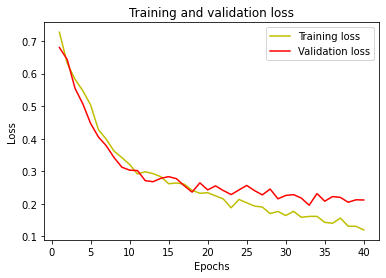

In [197]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

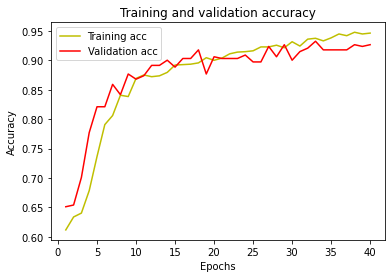

In [198]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The prediction for this image is:  [[1.]]
The actual label for this image is:  1


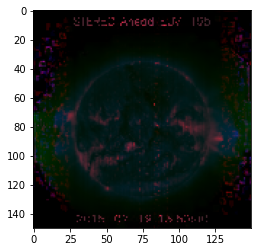

In [230]:
#########################################################################################
#Test the model on one image (for 300 epochs)
#img 23 is parasitized - correctly predicts near 0 probability
#Img 22, parasitized, correctly lables (low value) but relatively high value.
#img 24 is uninfected, correctly predicts as uninfected
#img 26 is parasitized but incorrectly gives high value for prediction, uninfected.

n=145 #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
# fig2 = plt.figure(figsize = (1,1)) # create a 5 x 5 figure 
# ax3 = fig2.add_subplot(111)
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 500

# ax3.imshow(img, interpolation='none')
# plt.imshow(img)


input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  [0.00265032]


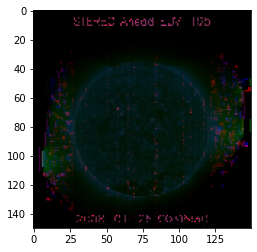

In [299]:
image_test = cv2.imread("/Users/ato/scripts/python_code/arIdentification/data/training_195/dataFetch/20080125_000530_n4euA_195.jpg")
# image_test = cv2.imread("/Users/ato/scripts/python_code/arIdentification/data/training_195/noAR/20190613_000530_n4euA_195.jpg")
image_test = Image.fromarray(image_test, 'RGB')
SIZE = 150
image = image_test.resize((SIZE, SIZE))
dataset_test= []
label_test = []
dataset_test.append(np.array(image))
X_today = normalize(dataset_test, axis=1)
todayImage = X_today[0]
plt.imshow(todayImage)
input_img = np.expand_dims(todayImage, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img)[0])

In [300]:
#Instead\ checking for each image, we can evaluate the model on all test data
#for accuracy
################################################################

#We can load the trained model, so we don't have to train again for 300 epochs!
from tensorflow.keras.models import load_model
# load model
model = load_model('AR_model_40epochs_195_test_92_67.h5')

In [302]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

#How do we know how it is doing for parasitized vs uninfected? 
################################################################

#Confusion matrix
#We compare labels and plot them based on correct or wrong predictions.
#Since sigmoid outputs probabilities we need to apply threshold to convert to label.

mythreshold=0.5
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
prop = model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

11/11 [==============================] - 1s 81ms/step - loss: 0.2119 - accuracy: 0.9267
Accuracy =  92.66862273216248 %
[[104  15]
 [ 10 212]]


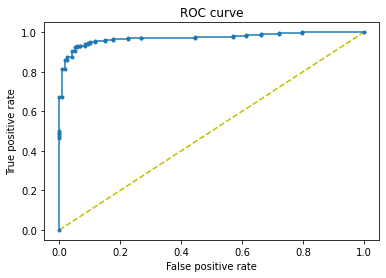

In [206]:
#Check the confusion matrix for various thresholds. Which one is good?
#Need to balance positive, negative, false positive and false negative. 
#ROC can help identify the right threshold.
##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us 
visualize the performance of a binary classifier when the threshold is varied. 
"""
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [303]:
"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  20    0.611463
Name: thresholds, dtype: float32


In [304]:
#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn


#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)


#########################################

Area under curve, AUC =  0.9718373836020895
